In [1]:
import bs4
import requests
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import pandas as pd
import numpy as np
from io import StringIO
import csv
import re
import fasttext

import nltk
from nltk.tokenize import word_tokenize

import joblib

In [2]:
stop_words = nltk.corpus.stopwords.words("russian")

In [3]:

class AvitoHelper:

    def __init__(self, vec_model, damage_model, docs_model, owner_model):
        self.session = requests.Session()
        self.session.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.54 Safari/537.36',
            'Accept-Language': 'ru',
        }
        
        self.vec_model = vec_model
        self.damage_model = damage_model
        self.docs_model = docs_model
        self.owner_model = owner_model
        
        
    def search(self, url, ads_quant=None):
        
        self.ads_quant = ads_quant
        
        self.search_page_url = url
        self.get_url_ads()
        
        if self.ads_quant!=None:
            for i in self.ad_url_list[:int(self.ads_quant)]:
                time.sleep(random.uniform(3, 6))
                self.inform('https://www.avito.ru' + i)
        else:
            for i in self.ad_url_list:
                time.sleep(random.uniform(3, 6))
                self.inform('https://www.avito.ru' + i)
            
        
        
                
        
    def inform(self, url):
        
        self.text1 = self.session.get(url).text
        self.url = url
        
        try:
            self.prep_text = self.get_text_preprocessed()
            self.text_vec = np.mean([self.vec_model.get_word_vector(x) for x in self.prep_text.split()], axis=0)
        except:
            print('Что-то пошло не так')
        
        print('Ссылка:', self.url)
        print(self.get_damage_classification())
        print(self.get_docs_classification())
        print(self.get_owner_classification())
        self.get_poko_prices()
        print('Цена авто:', self.get_price())
        
        if self.price < np.quantile(self.poko_prices, 0.25):
            print('Подходящая цена')
        else: 
            print('Неподходящая цена')
        
        if len(self.poko_prices) > 50:
            self.get_plot()

        
    
    def get_pokolenie_url(self):
        

        soup = bs4.BeautifulSoup(self.text1, 'lxml')

        cont = soup.select('a.js-breadcrumbs-link.js-breadcrumbs-link-interaction')
        self.pokolenie_url = str('https://www.avito.ru' + cont[-1].get('href') + '?radius=1000')
            
        return self.pokolenie_url
            

    def get_price(self):
        

        soup = bs4.BeautifulSoup(self.text1, 'lxml')

        cont = soup.select_one('span.js-item-price')
        self.price = int(cont.get('content'))
        return self.price
            
            
    def get_pages_lim(self, url):
        
        time.sleep(random.uniform(2, 5))

        text = self.session.get(url).text
        soup = bs4.BeautifulSoup(text, 'lxml')

        cont = soup.select('span.pagination-item-JJq_j')
        self.pages_lim = int(cont[-2].text)
        
        return self.pages_lim
            
            
    def get_url_pages(self):
        
        poko_url = self.get_pokolenie_url()
        page_lim = self.get_pages_lim(poko_url)
        
        try:
            if page_lim<5:
                self.url_list = [poko_url + '?p={}'.format(i) + '&radius=1000' for i in range(page_lim+1)[1:]]
            else:
                self.url_list = [poko_url + '?p={}'.format(i) + '&radius=1000' for i in range(6)[1:]]
        except:
            self.url_list = [poko_url + '?radius=1000']
        
        return self.url_list


    def get_url_pages_s(self):
        
        page_lim_global = self.get_pages_lim(self.search_page_url)
        
        if self.ads_quant!=None:
            if page_lim_global<(int(self.ads_quant/50)+1):
                page_lim = page_lim_global
            else:
                page_lim = (int(self.ads_quant/50)+1)
        else:
            page_lim = page_lim_global
        
        try:
            self.url_list_s = [self.search_page_url + '&p={}'.format(i) for i in range(page_lim+1)[1:]]
        except:
            self.url_list_s = [self.search_page_url]
        
        return self.url_list_s
    
    
    def get_url_ads(self):
        
        self.get_url_pages_s()
        
        ad_url_list = []
        
        for i in self.url_list_s[:1]:
            
            time.sleep(random.uniform(2, 4))
            
            text = self.session.get(i).text
            soup = bs4.BeautifulSoup(text, 'lxml')
            
            corp = soup.findAll('a', itemprop='url')
            for i in corp:
                ad_url_list.append(i.get('href'))
        
        self.ad_url_list = list(set(ad_url_list))
        
        return self.ad_url_list
    
            
            
            
    def get_poko_prices(self):
        
        url_list = self.get_url_pages()
        self.poko_prices = []

        for i in url_list:
            
            time.sleep(random.uniform(2, 4))
        
            url = i

            text = self.session.get(url).text
            soup = bs4.BeautifulSoup(text, 'lxml')

            cont = soup.select('span.price-price-BQkOZ')
            for i in cont:
                self.poko_prices.append(int(i.find('meta', itemprop="price").get('content')))
            
    
    def get_description(self):

        soup = bs4.BeautifulSoup(self.text1, 'lxml')

        self.description = soup.find('div', itemprop="description")
        
        return self.description
    
    
    def  get_text_preprocessed(self):
        
        text = self.get_description()
    
        text = re.sub(r'\<[^>]*\>',' ', str(text))
        text = re.sub(r'_+',' ', text)
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\s+[a-zA-Zа-яА-ЯёЁ]\s+', ' ', text)
        text = re.sub(r'\^[a-zA-Zа-яА-ЯёЁ]\s+', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()

        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]

        self.preprocessed_text = ' '.join(tokens)

        return self.preprocessed_text
    
    
    
    def get_damage_classification(self):
                
        pred = self.damage_model.predict(np.array([self.text_vec]))
        
        if pred[0] == 0:
            self.damage_answ = 'Не требуется ремонт'
        else:
            self.damage_answ = 'Требуется ремонт или не на ходу'

        return self.damage_answ
    
    
    
    def get_docs_classification(self):
                
        pred = self.docs_model.predict(np.array([self.text_vec]))
        
        if pred[0] == 0:
            self.docs_answ = 'Документы в порядке'
        else:
            self.docs_answ = 'Проблемы с документами'

        return self.docs_answ
    
    
    
    def get_owner_classification(self):
                
        pred = self.owner_model.predict(np.array([self.text_vec]))
        
        if pred[0] == 0:
            self.owner_answ = 'Не является частным собственником'
        else:
            self.owner_answ = 'Возможно, является частным собственником'

        return self.owner_answ
            
    
    def get_plot(self):
        
        if len(self.poko_prices) < 100:
            bins_quant = round(len(self.poko_prices)/5)
        else:
            bins_quant = round(len(self.poko_prices)/10)

        bin_num = int((self.price-min(self.poko_prices))/((max(self.poko_prices)-min(self.poko_prices))/bins_quant))
        n, bins, patches = plt.hist(self.poko_prices, bins=bins_quant, color='g', alpha=0.8, rwidth=0.9)
        patches[bin_num].set_fc('r')
        plt.show()
            
                

In [4]:
vm = fasttext.load_model("fil2.bin")
damm = joblib.load("model_damage.pkl")
docsm = joblib.load("model_docs.pkl")
owm = joblib.load("model_owner.pkl")

In [5]:
helper = AvitoHelper(vm, damm, docsm, owm)

Ссылка: https://www.avito.ru/moskva/avtomobili/bmw_x5_2004_2244606242
Требуется ремонт или не на ходу
Проблемы с документами
Возможно, является частным собственником
Цена авто: 379999
Подходящая цена


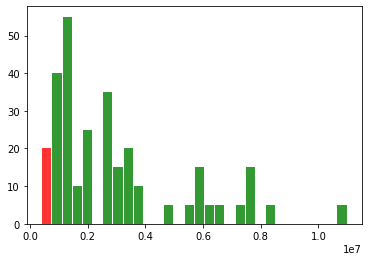

In [6]:
helper.inform('https://www.avito.ru/moskva/avtomobili/bmw_x5_2004_2244606242')

Ссылка: https://www.avito.ru/sankt-peterburg/avtomobili/mercedes-benz_gl-klass_2013_2247511408
Не требуется ремонт
Документы в порядке
Не является частным собственником
Цена авто: 2159000
Подходящая цена


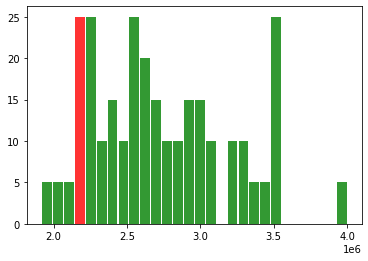

Ссылка: https://www.avito.ru/sankt-peterburg/avtomobili/skoda_octavia_2017_2265403527
Не требуется ремонт
Документы в порядке
Не является частным собственником
Цена авто: 1749000
Неподходящая цена


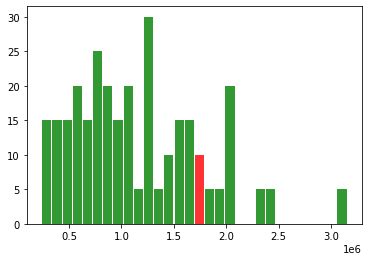

Ссылка: https://www.avito.ru/kudrovo/avtomobili/mercedes-benz_s-klass_2012_2212860099
Не требуется ремонт
Документы в порядке
Не является частным собственником
Цена авто: 1700000
Неподходящая цена


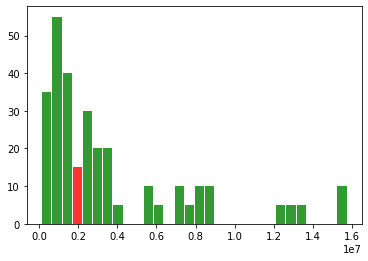

Ссылка: https://www.avito.ru/sankt-peterburg/avtomobili/mercedes-benz_gle-klass_2019_2242332255
Не требуется ремонт
Документы в порядке
Не является частным собственником
Цена авто: 5700000
Неподходящая цена


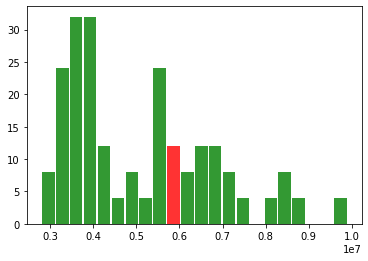

In [7]:
helper.search('https://www.avito.ru/sankt-peterburg/avtomobili/s_probegom-ASgBAgICAUSGFMjmAQ?radius=100', 4)